In [2]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git 

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

path = "/kaggle/working/clothing-dataset-small/train/t-shirt"
name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(299,299))
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7D01599A6D10>


In [5]:
from tensorflow.keras.preprocessing.image import load_img

In [6]:
path = "/kaggle/working/clothing-dataset-small/train/t-shirt"
name = "5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg"
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(299,299))
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7B4585A93070>


In [7]:
x = np.array(img)
x.shape

(299, 299, 3)

# 8.3

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights="imagenet", input_shape=(299,299,3))

91884032/91884032 [==============================] - 0s 0us/step


In [ ]:
X = np.array([x])
X.shape
X = preprocess_input(X)
X[0]

In [ ]:
pred = model.predict(X)

In [ ]:
pred.shape
decode_predictions(pred)

# 8.5

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_ds = train_gen.flow_from_directory("/kaggle/working/clothing-dataset-small/train", 
                              target_size=(150,150), 
                              batch_size=32)

Found 3068 images belonging to 10 classes.


In [ ]:
train_ds.class_indices

In [ ]:
!ls -l /kaggle/working/clothing-dataset-small/train

In [12]:
X, y = next(train_ds)

In [ ]:
X.shape

In [ ]:
y[:5]

In [12]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
"/kaggle/working/clothing-dataset-small/validation",
target_size=(150,150),
batch_size=32,
shuffle=False)

Found 341 images belonging to 10 classes.


In [13]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
preds = model.predict(X)

In [ ]:
preds.shape

In [ ]:
preds[0]

In [ ]:
learning_rate = 0.01

In [14]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10, validation_data=val_ds)

In [ ]:
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

# 8.6

In [ ]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights="imagenet", include_top=False, input_shape=(150,150,3))
    base_model.trainable = False

    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)
    
    ##################################
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    outputs = keras.layers.Dense(10)(vectors)

    model = keras.Model(inputs, outputs)
    ##################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
scores = {}

for lr in [0.0001,0.001,0.01,0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs = 10, validation_data = val_ds)
    scores[lr] = history.history
    print()
    print()

In [ ]:
del scores[0.1]
del scores[0.0001]

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

# 8.7

In [ ]:
model.save_weights('model_v1.h5', save_format='h5')

In [ ]:
'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5'.format(epoch=3, val_accuracy=0.84)

In [ ]:
checkpoint= keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                                           save_best_only=True,
                                           monitor="val_accuracy",
                                           mode='max')

In [ ]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=[checkpoint])
scores[lr] = history.history

# 8.8

In [15]:
def make_model(learning_rate=0.01, size_inner = 100):
    base_model = Xception(weights="imagenet", include_top=False, input_shape=(150,150,3))
    base_model.trainable = False

    

    
    
    ##################################
    inputs = keras.Input(shape=(150,150,3))
    base=base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)

    model = keras.Model(inputs, outputs)
    ##################################
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [16]:
learning_rate = 0.001
scores = {}

for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs = 10, validation_data = val_ds)
    scores[size] = history.history
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 21s 97ms/step - loss: 1.4821 - accuracy: 0.5241 - val_loss: 1.1309 - val_accuracy: 0.6540
Epoch 2/10
96/96 [==============================] - 7s 76ms/step - loss: 0.9651 - accuracy: 0.6816 - val_loss: 0.8906 - val_accuracy: 0.7038
Epoch 3/10
96/96 [==============================] - 7s 76ms/step - loss: 0.7586 - accuracy: 0.7471 - val_loss: 0.7463 - val_accuracy: 0.7537
Epoch 4/10
96/96 [==============================] - 7s 74ms/step - loss: 0.5902 - accuracy: 0.8061 - val_loss: 0.6453 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 7s 74ms/step - loss: 0.4842 - accuracy: 0.8416 - val_loss: 0.5991 - val_accuracy: 0.8240
Epoch 6/10
96/96 [==============================] - 7s 75ms/step - loss: 0.4198 - accuracy: 0.8634 - val_loss: 0.5895 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 7s 74ms/step - loss: 0.3620 - accuracy: 0.8898 - val_loss: 0.6017 - val_accuracy: 0.8152
Epoch 8/1

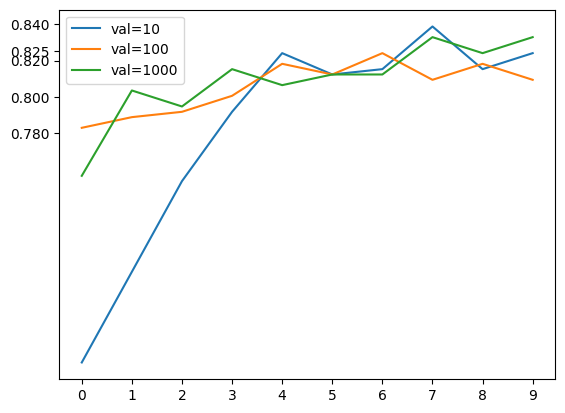

In [20]:
for lr, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.yticks([0.78,0.80,0.82,0.825,.84])
plt.legend()

# 8.9

In [5]:
def make_model(learning_rate=0.01, size_inner = 100, droprate=0.5):
    base_model = Xception(weights="imagenet", include_top=False, input_shape=(150,150,3))
    base_model.trainable = False
    
    ##################################
    
    inputs = keras.Input(shape=(150,150,3))
    base=base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    ##################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [26]:
learning_rate = 0.001
size = 100
scores = {}

for droprate in [0.0,0.2,0.5,0.8]:
    print(droprate)
    model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
    history = model.fit(train_ds, epochs = 30, validation_data = val_ds)
    scores[droprate] = history.history
    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 11s 83ms/step - loss: 0.9584 - accuracy: 0.6701 - val_loss: 0.6339 - val_accuracy: 0.8006
Epoch 2/30
96/96 [==============================] - 7s 74ms/step - loss: 0.4980 - accuracy: 0.8227 - val_loss: 0.5661 - val_accuracy: 0.8152
Epoch 3/30
96/96 [==============================] - 7s 74ms/step - loss: 0.3485 - accuracy: 0.8843 - val_loss: 0.6145 - val_accuracy: 0.7859
Epoch 4/30
96/96 [==============================] - 7s 74ms/step - loss: 0.2392 - accuracy: 0.9250 - val_loss: 0.6107 - val_accuracy: 0.8094
Epoch 5/30
96/96 [==============================] - 7s 74ms/step - loss: 0.1666 - accuracy: 0.9521 - val_loss: 0.5562 - val_accuracy: 0.8211
Epoch 6/30
96/96 [==============================] - 7s 74ms/step - loss: 0.1170 - accuracy: 0.9785 - val_loss: 0.6361 - val_accuracy: 0.7859
Epoch 7/30
96/96 [==============================] - 7s 73ms/step - loss: 0.0867 - accuracy: 0.9837 - val_loss: 0.5829 - val_accuracy: 0.8094
Epoch 8/

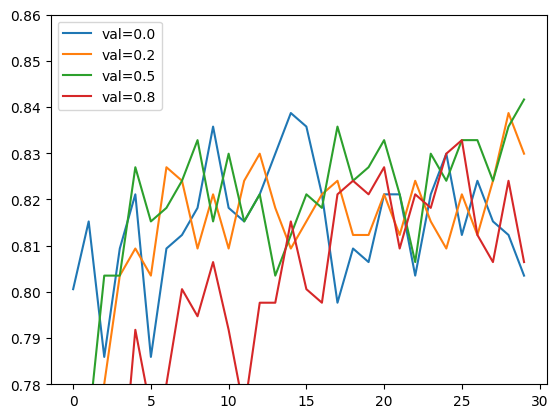

In [28]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

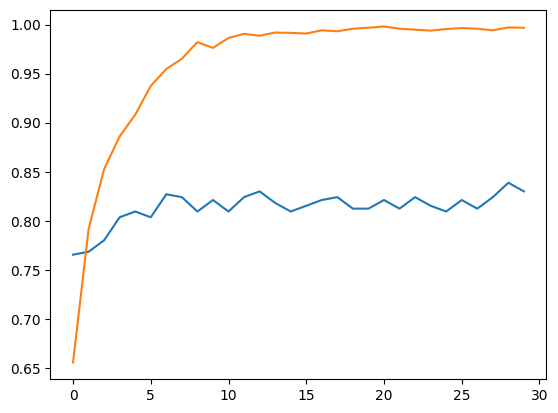

In [35]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.plot(hist['accuracy'], label=('val=%s' % droprate))


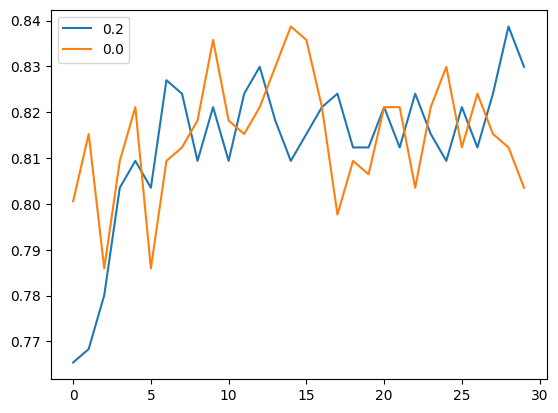

In [37]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)
plt.legend()

# 8.10

In [8]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True
                              )
train_ds = train_gen.flow_from_directory("/kaggle/working/clothing-dataset-small/train", 
                              target_size=(150,150), 
                              batch_size=32)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
"/kaggle/working/clothing-dataset-small/validation",
target_size=(150,150),
batch_size=32,
shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [9]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs = 50, validation_data = val_ds)



83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/50
96/96 [==============================] - 33s 226ms/step - loss: 1.3317 - accuracy: 0.5590 - val_loss: 0.7516 - val_accuracy: 0.7654
Epoch 2/50
96/96 [==============================] - 20s 210ms/step - loss: 0.9091 - accuracy: 0.6917 - val_loss: 0.6815 - val_accuracy: 0.7771
Epoch 3/50
96/96 [==============================] - 20s 208ms/step - loss: 0.7819 - accuracy: 0.7353 - val_loss: 0.6448 - val_accuracy: 0.7918
Epoch 4/50
96/96 [==============================] - 20s 213ms/step - loss: 0.6943 - accuracy: 0.7702 - val_loss: 0.6322 - val_accuracy: 0.7977
Epoch 5/50
96/96 [==============================] - 20s 210ms/step - loss: 0.6476 - accuracy: 0.7803 - val_loss: 0.6400 - val_accuracy: 0.7977
Epoch 6/50
96/96 [==============================] - 20s 209ms/step - loss: 0.6092 - accuracy: 0.7875 - val_loss: 0.6259 - val_accuracy: 0.7771
Epoch 7/50
96/96 [==============================] - 21s 215ms/step - loss: 0.

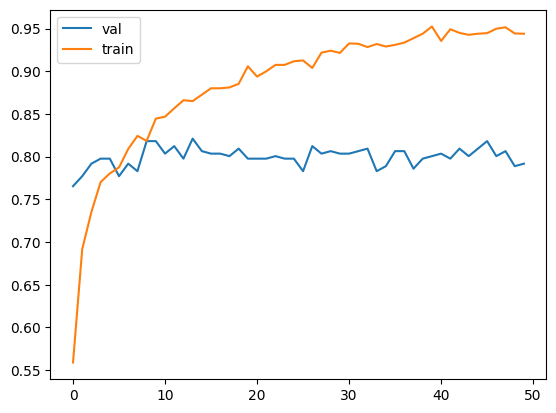

In [10]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend()

# 8.11

In [14]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size=299

In [15]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True
                              )
train_ds = train_gen.flow_from_directory("/kaggle/working/clothing-dataset-small/train", 
                              target_size=(input_size,input_size), 
                              batch_size=32)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    "/kaggle/working/clothing-dataset-small/validation",
    target_size=(input_size,input_size),
    batch_size=32,
    shuffle=False)
base_model = Xception(weights="imagenet", 
                          include_top=False, 
                          input_shape=(input_size,input_size,3))
base_model.trainable = False


def make_model(input_size=299,learning_rate=0.01, size_inner = 100, droprate=0.5):
   
    
    ##################################
    
    inputs = keras.Input(shape=(input_size,input_size,3))
    base=base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    ##################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [16]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')

In [17]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size=299
model = make_model(input_size=input_size, learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=[checkpoint])



Epoch 1/50
96/96 [==============================] - 74s 712ms/step - loss: 1.0664 - accuracy: 0.6542 - val_loss: 0.5667 - val_accuracy: 0.8094
Epoch 2/50
96/96 [==============================] - 65s 674ms/step - loss: 0.6800 - accuracy: 0.7669 - val_loss: 0.5134 - val_accuracy: 0.8328
Epoch 3/50
96/96 [==============================] - 65s 673ms/step - loss: 0.5761 - accuracy: 0.7992 - val_loss: 0.4689 - val_accuracy: 0.8475
Epoch 4/50
96/96 [==============================] - 65s 672ms/step - loss: 0.5244 - accuracy: 0.8282 - val_loss: 0.4195 - val_accuracy: 0.8592
Epoch 5/50
96/96 [==============================] - 63s 656ms/step - loss: 0.4813 - accuracy: 0.8396 - val_loss: 0.4093 - val_accuracy: 0.8592
Epoch 6/50
96/96 [==============================] - 64s 668ms/step - loss: 0.4503 - accuracy: 0.8481 - val_loss: 0.4388 - val_accuracy: 0.8475
Epoch 7/50
96/96 [==============================] - 64s 661ms/step - loss: 0.4057 - accuracy: 0.8582 - val_loss: 0.3965 - val_accuracy: 0.8475

KeyboardInterrupt: 

# 8.12

In [25]:
model = keras.models.load_model('/kaggle/working/xception_v4_21_0.874.h5') # 0.89.8
# model = keras.models.load_model('/kaggle/working/xception_v4_14_0.865.h5') # 0.88.4

In [26]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "/kaggle/working/clothing-dataset-small/test/",
    target_size=(299,299),
    batch_size=32,
    shuffle=False)

Found 372 images belonging to 10 classes.


In [27]:
model.evaluate(test_ds)

12/12 [==============================] - 4s 225ms/step - loss: 0.3040 - accuracy: 0.8978


[0.3039816915988922, 0.897849440574646]

In [28]:
path = "/kaggle/working/clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg"

In [32]:
img = load_img(path, target_size=(299,299))

In [33]:
x=np.array(img)
X=np.array([x])
X.shape

(1, 299, 299, 3)

In [34]:
X = preprocess_input(X)

In [37]:
pred = model.predict(X)
classes= ["dress",
         "hat",
         "longsleeve",
         "outwear",
         "pants",
         "shirt",
         "shoes",
         "shorts",
         "skirt",
         "t-shirt"
]

1/1 [==============================] - 0s 24ms/step


In [39]:
dict(zip(classes,pred[0]))

{'dress': -3.1102545,
 'hat': -6.5845356,
 'longsleeve': -0.8034689,
 'outwear': -1.915237,
 'pants': 10.255589,
 'shirt': -2.1208942,
 'shoes': -5.05567,
 'shorts': 4.177712,
 'skirt': -2.0554976,
 't-shirt': -7.9233694}